## HALF-QAE 

In [1]:
import matplotlib.pyplot as plt
import pylab
import math
import copy
import os.path as path
import time
import warnings

from IPython.display import clear_output

from qae_utils.Files import create_folder_if_needed, read_json_file, read_ts_file
from qae_utils.Charts import multi_plot_flat_ts, meas_plot
from qae_utils.Tools import draw_circuit
from qae_utils.Window import ts_wind_make, ts_wind_split, ts_wind_flatten_avg
from qae_utils.Window import ts_calc_noise, ts_add_noise

from matplotlib import set_loglevel
set_loglevel("error")
%matplotlib inline

In [2]:
### Constants
LOG_NAME = 'aintern'
DATA_NAME = 'mackey_glass'
CASE_NAME = 'full_qae'
DATA_PATH = f'{LOG_NAME}/data'
FIGURES_PATH = f'{LOG_NAME}/figures'
TRAIN_PATH = f'{LOG_NAME}/training'
PARAMS_PATH = f'{LOG_NAME}/params'
ANALYSIS_PATH = f'{LOG_NAME}/analysis'

### Create a folder if needed
create_folder_if_needed(FIGURES_PATH)
create_folder_if_needed(TRAIN_PATH)
create_folder_if_needed(PARAMS_PATH)
create_folder_if_needed(ANALYSIS_PATH)

### Show constants
(LOG_NAME, CASE_NAME, DATA_NAME,DATA_PATH, TRAIN_PATH, PARAMS_PATH, ANALYSIS_PATH, FIGURES_PATH)

('aintern',
 'full_qae',
 'mackey_glass',
 'aintern/data',
 'aintern/training',
 'aintern/params',
 'aintern/analysis',
 'aintern/figures')

In [3]:
### Identify data to loaded
DATA_ID = 'mackey_glass_n100'

In [4]:
# Load repository info
data_info_path = f'{DATA_PATH}/{DATA_ID}/info.json'
data_info = read_json_file(data_info_path)
data_info


{'data_name': 'mackey_glass',
 'major_version': 6,
 'minor_version': 0,
 'samples': 100,
 'scale_margin': 0.2,
 'scale_low': 0.2,
 'scale_high': 0.8,
 'mackey_glass_beta': 0.25,
 'mackey_glass_gamma': 0.1,
 'mackey_glass_n': 10,
 'mackey_glass_tau': 15,
 'mackey_glass_dt': 1.0,
 'mackey_glass_T': 300}

In [5]:
### Set the version of this notebook
major_version = 6
minor_version = 0
debug_level = 2

In [6]:
### Load all data hyper-parameters

# Software version
data_major_version = data_info['major_version']
data_minor_version = data_info['minor_version']

# Data settings
samples = data_info['samples']
scale_margin = data_info['scale_margin']
scale_low = data_info['scale_low']
scale_high = data_info['scale_high']

In [7]:
### Define file names
#   Note that data files have alreay been 0..pi encoded
x_org_fpath = f'{DATA_PATH}/{DATA_ID}/x_org.arr'
y_org_fpath = f'{DATA_PATH}/{DATA_ID}/y_org.arr'

In [8]:
### Load the data set
X = read_ts_file(x_org_fpath).astype(int)
y = read_ts_file(y_org_fpath)

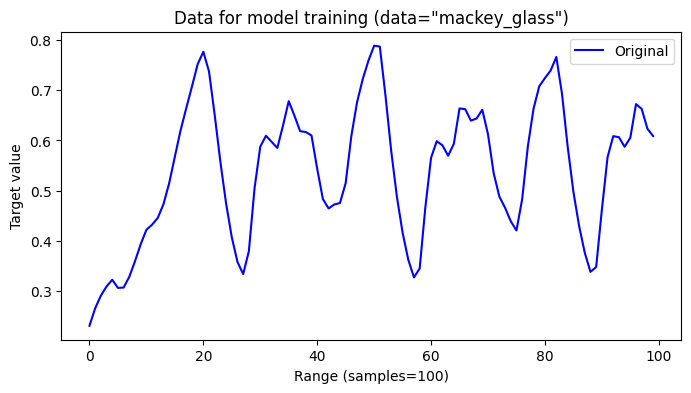

In [9]:
### Plot loaded TSs
X_list = [0]
y_list = [y]

# print(f'y_train_ts.shape = {y_train_ts.shape}')
# print(f'y_test_ts.shape = {y_test_ts.shape}')

print()
multi_plot_flat_ts(y_list, X_list=X_list,
    colors = ['blue'],
    labels = ['Original'],
    lines = ['solid'], legend_cols=1, 
    rcParams=(8, 4), #ylim=(0, 3.5),
    xlabel=f'Range (samples={samples})',
    title=f'Data for model training (data="{DATA_NAME}")'
    )
print()

In [10]:
### Libraries used in QAE development

# PennyLane imports
import pennylane as qml
from pennylane import numpy as np

In [11]:
### All created files have the following codes:
#   n: sample size
#   w: window size
#   ws: window step
#   z: level of noise injected
#   zr: replication number of noisy records
TRAIN_PREF = f'{CASE_NAME}_{DATA_ID}'
TRAIN_PREF

'full_qae_mackey_glass_n100'

In [12]:
### Counts the number of pytorch model parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Gets all pytorch parameters
def get_param_vals(model):
    params = []
    for param in model.parameters():
        params.append(param.view(-1))
    params = torch.cat(params)
    params = params.cpu().detach().flatten() # [0]
    return params.numpy()

In [13]:
### Run specific architectural + training param
#   These parameter values can be set from the test data

### Data params
split = 0.75
train_size = int(samples*split)     # Use the first train_size points for training
test_size = samples - train_size    # Use the next test_size points for testing

wind_size = 5
wind_step = 2
horizon = 1

noise = 0.1 # This is max absolute, in relation to value range (0, 1)

### Model params
rot = 'Rxyz' # Ry / Rxyz
n_layers = 5
n_latent = 3
n_extra = 2
n_epochs = 200 # 1000 # 2000
log_interv = 1
param_scaler = 0.1

### Derived params
n_trash = wind_size - n_latent
n_data = n_latent + n_trash
n_wires = n_latent + n_trash + n_extra

### Other (CASE_NAME) invariant params
diff_method = 'best'
interface = None # we will use default
level='gradient'
shuffle_interv = 0
cost_type = 'MSE'
cost_yscale = 'linear' # linear, log
shots = None # We use a state vector simulator

### Currently are not generated here, but QAE models should run 10 times with diff inits
#   The number of times the model should be run with different initial params
#   Each instance history and params should be saved and later used
n_inst = 1

### Random seed(s)
#   We may need to create different seeds for each model instance

seed = 2024

if seed == 0: 
    np.random.seed(rand_seed())
else:
    np.random.seed(seed)
inst_seeds = [int(n) for n in np.random.randint(0, high=9999, size=n_inst)]

In [14]:
### Quantum simulator
sim = 'default.qubit' # default.qubit lightning.qubit lightning.gpu

In [15]:
### Create time series tensor data with optional noise (note that windows overlap by wind_step)
def create_sw_tens(X, y, noise=0.0, wind_size=5, wind_step=2):
    y_ts = ts_wind_make(ts_add_noise(y, noise), wind_size, wind_step)
    X_ts = np.array([i*wind_step for i in range(len(y_ts))])
    X_train_ts, y_train_ts, X_test_ts, y_test_ts = ts_wind_split(X_ts, y_ts, split)

    X_train_tens = np.tensor(X_train_ts, requires_grad=False)
    y_train_tens = np.tensor(y_train_ts, requires_grad=False)
    X_test_tens = np.tensor(X_test_ts, requires_grad=False)
    y_test_tens = np.tensor(y_test_ts, requires_grad=False)
    return X_train_tens, y_train_tens, X_test_tens, y_test_tens

In [16]:
### Our own gradient-friendly loss/cost function
#   Beware in PennyLane these MUST be very pure
#   to be differentiable (so not external / fancy functions)
def mse_cost_on_tensors(targets, predictions):
    cost = 0
    vals = 0
    for i in range(len(targets)):
        for w in range(len(targets[i])):
            cost = cost + (targets[i][w] - predictions[i][w]) ** 2
            vals += 1
    cost = cost / vals
    return cost

### The cost function generator
def cost_fun_gen_on_tensors(model, cost_fun):
    def _cost_fun(params, inputs, targets):
        nonlocal model, cost_fun
        preds = [model(params, x) for x in inputs]
        return cost_fun(targets, preds)
    return _cost_fun

In [18]:
## Half QAE shape

#   n_latent: number of latent qubits
#   n_trash: number of trash qubits
#   n_layers: number of layers (repeats)
#   returns: shape
def half_qae_shape(n_latent, n_trash, n_extra=0, n_layers=1, rot='Ry'):
    n_wires = n_latent + n_trash + n_extra
    if rot == 'Ry':
        shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
    elif  rot == 'Rxyz':
        shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
    return shape

In [19]:
## HALF QAE 
def half_qae(wires, n_latent, n_trash, n_layers=1, rot='Ry'):

    latent_wires = wires[:n_latent]
    trash_wires  = wires[n_latent:n_latent+n_trash]
    data_wires   = latent_wires + trash_wires
    anz_wires    = data_wires

    # Encodes a sequence on in put (similar to AngleEncoding)
    def _sequence_encoder(wires, inputs):
        n_inputs = len(inputs)
        n_wires = len(wires)
    
        for w in wires:
            # qml.Hadamard(wires=w)
            if w > n_inputs-1:
                qml.RY(0, wires=w)
            else:
                qml.RY(inputs[w], wires=w)
    
    ### Entangler shape
    def _entangler_shape(n_layers, n_wires, rot='Ry'):
        if rot == 'Ry':
            return qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
        elif rot == 'Rxyz':
            return qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
        else:
            return ()
        
    ### Entangler
    def _entangler(wires, weights, rot='Ry'):
        if rot == 'Ry':
            qml.BasicEntanglerLayers(weights, wires=anz_wires, rotation=qml.RY)
        elif rot == 'Rxyz':
            qml.StronglyEntanglingLayers(weights, wires=anz_wires)

    def _half_qae(weights, inputs):

        _sequence_encoder(data_wires, inputs)
        qml.Barrier(wires)
        shape = _entangler_shape(n_layers, len(anz_wires), rot=rot)
        w = weights.reshape(shape)
        _entangler(anz_wires, w, rot=rot)
        return [qml.expval(qml.PauliZ(w)) for w in trash_wires]

    return _half_qae

In [20]:
##### Create a model

wires = list(range(n_latent + n_trash))

### Check the HALF QAE shape
shape = half_qae_shape(n_latent, n_trash, n_layers=n_layers, rot=rot)
n_weights = np.prod(shape)
print(f'Half-QAE shape: {shape}, weights: {int(n_weights)}\n')
sample_params = np.random.uniform(high=param_scaler, size=shape, requires_grad=True)
sample_data = np.linspace(100, 200, n_latent + n_trash, requires_grad=False)

Half-QAE shape: (5, 5, 3), weights: 75



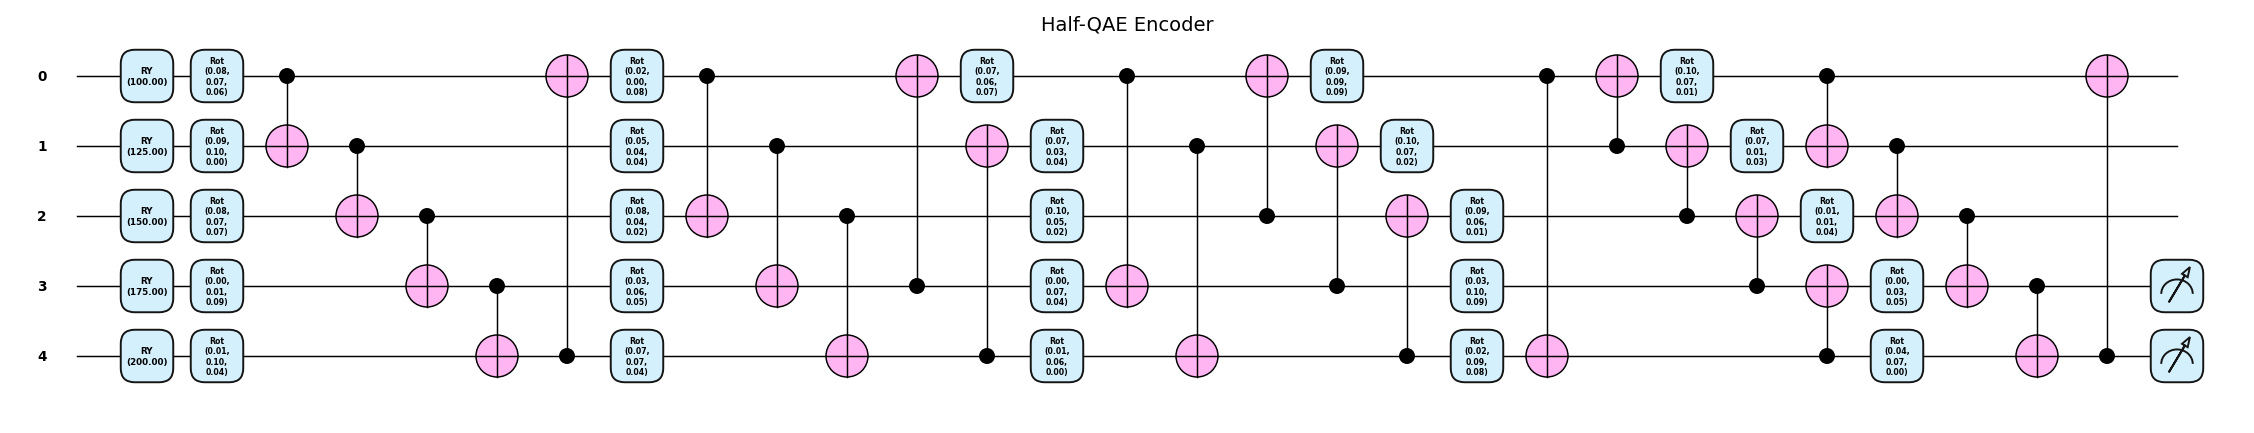

In [21]:
qae = half_qae(wires, n_latent, n_trash, n_layers=n_layers, rot=rot)

# Create and draw a half-QAE
dev = qml.device(sim, wires = wires, shots=shots, seed=seed)
half_qae_model = qml.QNode(qae, dev)
draw_circuit(half_qae_model, scale=0.7, title='Half-QAE Encoder', level='device') \
    (sample_params, sample_data) # expansion_strategy='device'/'gradient'

In [26]:
_, y_train_pure_tens, _, _ = create_sw_tens(X, y, noise=0, wind_size=wind_size, wind_step=wind_step)

In [27]:
##### Prepare for training

### For reproducibility
np.random.seed(seed)

### Select one of the following optimisers built into PennyLane
# opt = qml.GradientDescentOptimizer(stepsize=0.5)
# opt = qml.RMSPropOptimizer(stepsize=0.1, decay=0.7, eps=1e-08)
# opt = qml.NesterovMomentumOptimizer(stepsize=0.5)
# opt = RCDOptimizer(h=0.1)
opt = qml.AdamOptimizer(stepsize=0.5)

In [28]:
##### Training loop

def train_trash(model, X, y, loss_fun, optimizer, n_epochs, init_weights=None, 
                     log_interv=100, prompt_fract=0.1, start_time=0, level=2, seed=0,
                     wind_size=8, wind_step=4, noise=0, weight_scaler=0.1):

    ### For reproducibility
    #   Set a default random seed
    if seed == 0: seed = int(time.time()*1000) % 10000
    np.random.seed(seed)
    
    ### Define the cost function
    cost_fun = cost_fun_gen_on_tensors(model, loss_fun)
    
    ### Prepare training
    hist_cost = []
    hist_params = []
    
    ### Set initial weights/parameters
    if init_weights is None:
        init_weights = np.random.uniform(high=np.pi, size=shape, requires_grad=True)*weight_scaler
    params = init_weights.copy()
    
    ### Prepare tensors of pure training windows to be used as y output
    #   We ignore the test partition in training
    _, y_pure_tens, _, _ = create_sw_tens(X, y, noise=0, 
        wind_size=wind_size, wind_step=wind_step)
    #y_trash_tens = np.zeros((len(y_train_pure_tens), n_trash))
    
    ### Set the clock
    if start_time == 0: start_time = time.time() 
        
    ### Training loop
    for iter in range(n_epochs):
    
        # Add noise to pure windows to be used as X input
        #   We ignore the test partition in training
        #_, X_noisy_tens, _, _ = create_sw_tens(X, y, noise=noise, 
            #wind_size=wind_size, wind_step=wind_step)
        y_trash_tens = np.zeros((len(y_train_pure_tens), n_trash))
    
        params, cost = optimizer.step_and_cost(lambda p: cost_fun(p, y_pure_tens, y_trash_tens), params)
        elapsed_time = time.time()-start_time
        if iter % log_interv == 0:
            hist_cost.append(cost)
            hist_params.append(params)
        if (prompt_fract == 0) or (iter % int(prompt_fract*n_epochs) == 0):
            print(f'Iter: {iter:03d} ({int(elapsed_time):03d} sec) cost={np.round(cost, 6)}')
    
    ### Print the training summary
    min_cost = np.min(hist_cost)
    min_iter = np.argmin(hist_cost)
    opt_params = hist_params[min_iter]
    
    ### Print the training summary
    print(f'\nTraining completed: epochs={n_epochs}, min cost={np.round(min_cost, 6)} @ {min_iter}, time={int(elapsed_time):03d} secs\n')

    return hist_cost, hist_params, init_weights, (min_iter, min_cost, elapsed_time)

In [29]:
hist_cost, hist_params, init_weights, stats = train_trash(
    half_qae_model,
    X, y, mse_cost_on_tensors, opt, n_epochs,
    wind_size=wind_size, wind_step=wind_step, noise=0,
    log_interv=log_interv, prompt_fract=0.1, start_time=0, level=2, seed=seed
)

Iter: 000 (001 sec) cost=0.298325
Iter: 020 (038 sec) cost=0.006328
Iter: 040 (074 sec) cost=0.002198
Iter: 060 (111 sec) cost=0.000241
Iter: 080 (151 sec) cost=6.1e-05
Iter: 100 (192 sec) cost=8.4e-05
Iter: 120 (235 sec) cost=0.028542
Iter: 140 (275 sec) cost=0.048586
Iter: 160 (314 sec) cost=0.002616
Iter: 180 (353 sec) cost=0.000245

Training completed: epochs=200, min cost=8e-06 @ 94, time=416 secs



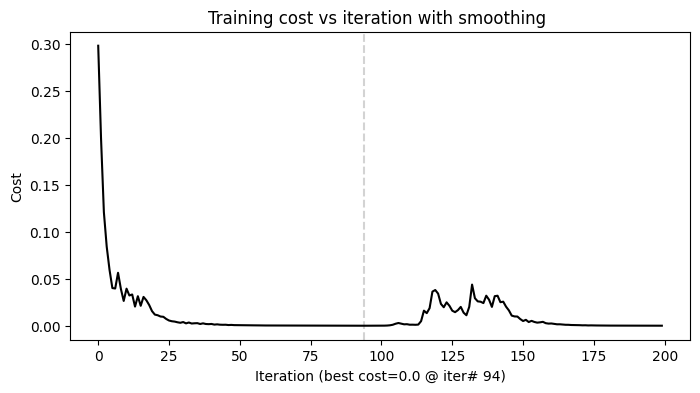

In [30]:
### Plot training cost
#   Note that best model may not have been saved
#   because models are being saved at predefined intervals (log_interv)
meas_plot(hist_cost, meas='cost', task='min', title_pref='Training',
    rcParams=(8, 4), log_interv=log_interv,
    backplot=False, back_color='linen', smooth_weight=0.6,
    save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}/train_sample_cost.eps')

In [31]:
# params of model
best_params = hist_params[stats[0]]

In [32]:
### Save the current model results info the log 
from qae_utils.Files import write_pickle_file
inst = n_inst-1 # There is only one at the moment
history_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/inst_{inst:03d}/hist_half_qae.pkl'
init_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/inst_{inst:03d}/init_half_qae.pkl'
params_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/inst_{inst:03d}/params_half_qae.pkl'
write_pickle_file(history_fpath, hist_cost)
write_pickle_file(init_fpath, init_weights.numpy())
write_pickle_file(params_fpath, np.stack(hist_params).numpy())

## HALF-QAE Dagger (HALF-QAE)

In [33]:
best_params_flip = np.flip(best_params, axis=0)

In [34]:
### Half QAE shape dagger
#   n_latent: number of latent qubits
#   n_trash: number of trash qubits
#   n_layers: number of layers (repeats)
#   returns: shape
def half_qae_shape_dagger(n_latent, n_trash, n_extra=0, n_layers=1, rot='Ry'):
    n_wires = n_latent + n_trash + n_extra
    if rot == 'Ry':
        shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
    elif  rot == 'Rxyz':
        shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
    return shape

In [35]:
### Half QAE dagger
def half_qae_dagger(wires, n_latent, n_trash, n_layers=1, rot='Ry'):

    latent_wires = wires[:n_latent]
    trash_wires  = wires[n_latent:n_latent+n_trash]
    data_wires   = latent_wires + trash_wires
    anz_wires    = data_wires

    # Encodes a sequence on in put (similar to AngleEncoding)
    def _sequence_encoder(wires, inputs):
        n_inputs = len(inputs)
        n_wires = len(wires)
    
        for w in wires:
            # qml.Hadamard(wires=w)
            if w > n_inputs-1:
                qml.RY(0, wires=w)
            else:
                qml.RY(inputs[w], wires=w)
    
    ### Entangler shape
    def _entangler_shape(n_layers, n_wires, rot='Ry'):
        if rot == 'Ry':
            return qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
        elif rot == 'Rxyz':
            return qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
        else:
            return ()
        
    ### Entangler
    def _entangler(wires, weights, rot='Ry'):
        if rot == 'Ry':
            qml.BasicEntanglerLayers(weights, wires=anz_wires, rotation=qml.RY)
        elif rot == 'Rxyz':
            qml.StronglyEntanglingLayers(weights, wires=anz_wires)

    def _half_qae_dagger(weights, inputs):

        _sequence_encoder(data_wires, inputs)
        qml.Barrier(wires)
        shape = _entangler_shape(n_layers, len(anz_wires), rot=rot)
        w = weights.reshape(shape)
        qml.adjoint(_entangler)(anz_wires, w, rot=rot)
        return [qml.expval(qml.PauliZ(w)) for w in latent_wires + trash_wires]

    return _half_qae_dagger

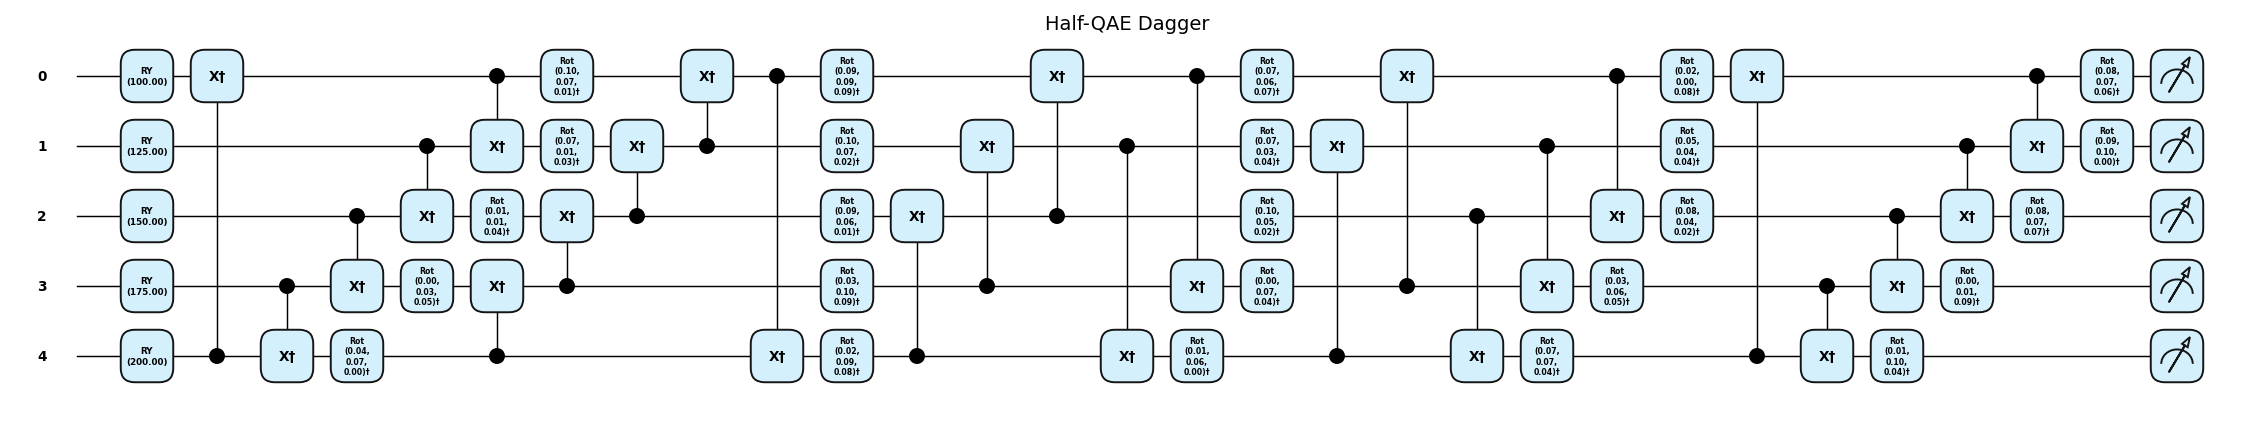

In [36]:
qae = half_qae_dagger(wires, n_latent, n_trash, n_layers=n_layers, rot=rot)

# Create and draw a half-QAE dagger
dev = qml.device(sim, wires = wires, shots=shots, seed=seed)
half_qae_dagger_model = qml.QNode(qae, dev)
draw_circuit(half_qae_dagger_model, scale=0.7, title='Half-QAE Dagger', level='device') \
    (sample_params, sample_data) # expansion_strategy='device'/'gradient'

In [37]:
##### Training loop

def train_without_noise(model, X, y, loss_fun, optimizer, n_epochs, init_weights=None, 
                     log_interv=100, prompt_fract=0.1, start_time=0, level=2, seed=0,
                     wind_size=8, wind_step=4, noise=0, weight_scaler=0.1):

    ### For reproducibility
    #   Set a default random seed
    if seed == 0: seed = int(time.time()*1000) % 10000
    np.random.seed(seed)
    
    ### Define the cost function
    cost_fun = cost_fun_gen_on_tensors(model, loss_fun)
    
    ### Prepare training
    hist_cost = []
    hist_params = []
    
    ### Set initial weights/parameters
    if init_weights is None:
        init_weights = np.random.uniform(high=np.pi, size=shape, requires_grad=True)*weight_scaler
    params = init_weights.copy()
    
    ### Prepare tensors of pure training windows to be used as y output
    #   We ignore the test partition in training
    _, y_pure_tens, _, _ = create_sw_tens(X, y, noise=0, 
        wind_size=wind_size, wind_step=wind_step)

    
    ### Set the clock
    if start_time == 0: start_time = time.time() 
        
    ### Training loop
    for iter in range(n_epochs):
    
        # Add noise to pure windows to be used as X input
        #   We ignore the test partition in training
        _, X_noisy_tens, _, _ = create_sw_tens(X, y, noise=0, 
            wind_size=wind_size, wind_step=wind_step)
    
        params, cost = optimizer.step_and_cost(lambda p: cost_fun(p, X_noisy_tens, y_pure_tens), params)
        elapsed_time = time.time()-start_time
        if iter % log_interv == 0:
            hist_cost.append(cost)
            hist_params.append(params)
        if (prompt_fract == 0) or (iter % int(prompt_fract*n_epochs) == 0):
            print(f'Iter: {iter:03d} ({int(elapsed_time):03d} sec) cost={np.round(cost, 6)}')
    
    ### Print the training summary
    min_cost = np.min(hist_cost)
    min_iter = np.argmin(hist_cost)
    opt_params = hist_params[min_iter]
    
    ### Print the training summary
    print(f'\nTraining completed: epochs={n_epochs}, min cost={np.round(min_cost, 6)} @ {min_iter}, time={int(elapsed_time):03d} secs\n')

    return hist_cost, hist_params, init_weights, (min_iter, min_cost, elapsed_time)

In [38]:
hist_cost, hist_params, init_weights, stats = train_without_noise(
    half_qae_dagger_model,
    X, y, mse_cost_on_tensors, opt, n_epochs, init_weights=best_params_flip,
    wind_size=wind_size, wind_step=wind_step, noise=0,
    log_interv=log_interv, prompt_fract=0.1, start_time=0, level=2, seed=seed
)

Iter: 000 (002 sec) cost=0.317114
Iter: 020 (039 sec) cost=0.017728
Iter: 040 (079 sec) cost=0.004298
Iter: 060 (118 sec) cost=0.001927
Iter: 080 (180 sec) cost=0.00131
Iter: 100 (266 sec) cost=0.0011
Iter: 120 (306 sec) cost=0.00096
Iter: 140 (347 sec) cost=0.000847
Iter: 160 (388 sec) cost=0.000754
Iter: 180 (428 sec) cost=0.000684

Training completed: epochs=200, min cost=0.000641 @ 199, time=467 secs



In [39]:
### Save the current model results info the log 
from qae_utils.Files import write_pickle_file
inst = n_inst-1 # There is only one at the moment
history_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/inst_{inst:03d}/hist_half_qae_dagger.pkl'
init_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/inst_{inst:03d}/init_half_qae_dagger.pkl'
params_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/inst_{inst:03d}/params_half_qae_dagger.pkl'
write_pickle_file(history_fpath, hist_cost)
write_pickle_file(init_fpath, init_weights.numpy())
write_pickle_file(params_fpath, np.stack(hist_params).numpy())

In [40]:
best_params_dagger = hist_params[stats[0]]

In [41]:
### Add noise to pure data to create a sample noisy data

# Create a sample of pure and noisy training and test tensors
X_train_pure_tens, y_train_pure_tens, X_test_pure_tens, y_test_pure_tens = \
    create_sw_tens(X, y, noise=0, wind_size=wind_size, wind_step=wind_step)

# Flatten original TSs for plotting
y_train_pure_flat = ts_wind_flatten_avg(y_train_pure_tens, wind_step)
y_test_pure_flat = ts_wind_flatten_avg(y_test_pure_tens, wind_step)

In [42]:
### Reconstruct pure and noisy training TSs
pred_train_from_pure_tens = np.stack([half_qae_dagger_model(best_params_dagger, x) for x in y_train_pure_tens], requires_grad=False)
pred_test_from_pure_tens = np.stack([half_qae_dagger_model(best_params_dagger, x) for x in y_test_pure_tens], requires_grad=False)


### Flatten recovered TSs
pred_train_from_pure_flat = ts_wind_flatten_avg(pred_train_from_pure_tens, wind_step)
pred_test_from_pure_flat = ts_wind_flatten_avg(pred_test_from_pure_tens, wind_step)

In [44]:
### Calculate metrics to show in charts
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mse_train_pure_vs_rec_from_pure = mean_squared_error(y_train_pure_flat, pred_train_from_pure_flat)
mse_test_pure_vs_rec_from_pure = mean_squared_error(y_test_pure_flat, pred_test_from_pure_flat)

print(f'MSE train pure vs recovered = {mse_train_pure_vs_rec_from_pure:0.8f}')
print(f'MSE test  pure vs recovered = {mse_test_pure_vs_rec_from_pure:0.8f}')

MSE train pure vs recovered = 0.00041413
MSE test  pure vs recovered = 0.00054597


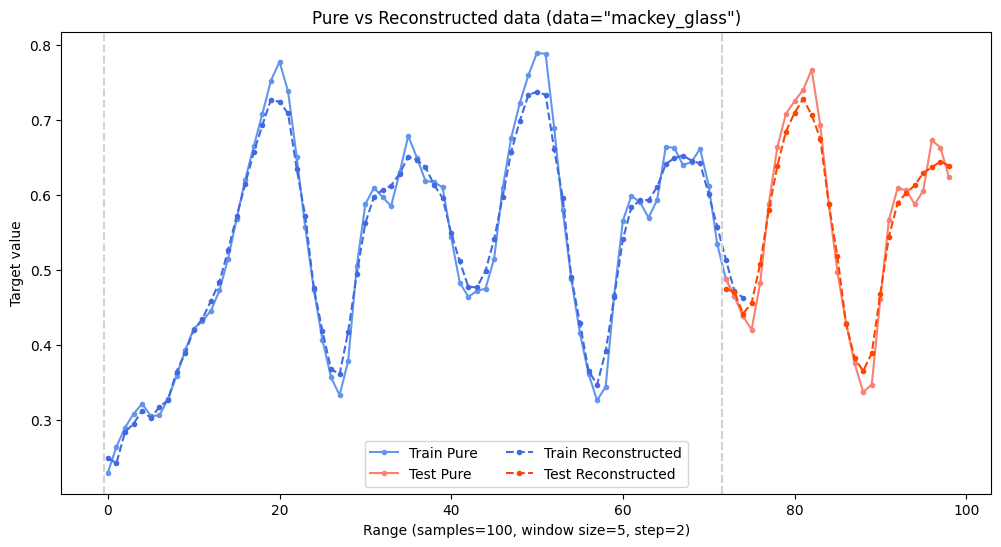

In [46]:
### Plot the original and recovered data


# Prepare X, y lists for plotting
X_list = [X_train_pure_tens[0], X_test_pure_tens[0],  
          X_train_pure_tens[0], X_test_pure_tens[0]]
y_list = [y_train_pure_flat, y_test_pure_flat, 
          pred_train_from_pure_flat, pred_test_from_pure_flat]


print()
multi_plot_flat_ts(
    y_list, X_list=X_list,
    colors=['cornflowerblue', 'salmon', 'royalblue', 'orangered'],
    marker_colors=['cornflowerblue', 'salmon', 'royalblue', 'orangered'],
    labels=['Train Pure', 'Test Pure', 'Train Reconstructed', 'Test Reconstructed'],
    lines=['solid', 'solid', 'dashed', 'dashed'],
    markers=['.', '.', '.', '.'],
    legend_cols=2,
    title=f'Pure vs Reconstructed data (data="{DATA_NAME}")',
    xlabel=f'Range (samples={samples}, window size={wind_size}, step={wind_step})',
    #save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}/train_org_vs_recovered.eps'
)
print()

## TRAINING WITH NOISE

In [47]:
##### Training loop

def train_with_noise_trash(model, X, y, loss_fun, optimizer, n_epochs, init_weights=None, 
                     log_interv=100, prompt_fract=0.1, start_time=0, level=2, seed=0,
                     wind_size=8, wind_step=4, noise=0, weight_scaler=0.1):

    ### For reproducibility
    #   Set a default random seed
    if seed == 0: seed = int(time.time()*1000) % 10000
    np.random.seed(seed)
    
    ### Define the cost function
    cost_fun = cost_fun_gen_on_tensors(model, loss_fun)
    
    ### Prepare training
    hist_cost = []
    hist_params = []
    
    ### Set initial weights/parameters
    if init_weights is None:
        init_weights = np.random.uniform(high=np.pi, size=shape, requires_grad=True)*weight_scaler
    params = init_weights.copy()
    
    ### Prepare tensors of pure training windows to be used as y output
    #   We ignore the test partition in training
    _, y_pure_tens, _, _ = create_sw_tens(X, y, noise=0, 
        wind_size=wind_size, wind_step=wind_step)
    y_trash_tens = np.zeros((len(y_train_pure_tens), n_trash))
    
    ### Set the clock
    if start_time == 0: start_time = time.time() 
        
    ### Training loop
    for iter in range(n_epochs):
    
        # Add noise to pure windows to be used as X input
        #   We ignore the test partition in training
        _, X_noisy_tens, _, _ = create_sw_tens(X, y, noise=noise, 
            wind_size=wind_size, wind_step=wind_step)
    
        params, cost = optimizer.step_and_cost(lambda p: cost_fun(p, X_noisy_tens, y_trash_tens), params)
        elapsed_time = time.time()-start_time
        if iter % log_interv == 0:
            hist_cost.append(cost)
            hist_params.append(params)
        if (prompt_fract == 0) or (iter % int(prompt_fract*n_epochs) == 0):
            print(f'Iter: {iter:03d} ({int(elapsed_time):03d} sec) cost={np.round(cost, 6)}')
    
    ### Print the training summary
    min_cost = np.min(hist_cost)
    min_iter = np.argmin(hist_cost)
    opt_params = hist_params[min_iter]
    
    ### Print the training summary
    print(f'\nTraining completed: epochs={n_epochs}, min cost={np.round(min_cost, 6)} @ {min_iter}, time={int(elapsed_time):03d} secs\n')

    return hist_cost, hist_params, init_weights, (min_iter, min_cost, elapsed_time)

In [48]:
hist_cost, hist_params, init_weights, stats = train_with_noise_trash(
    half_qae_model,
    X, y, mse_cost_on_tensors, opt, n_epochs,
    wind_size=wind_size, wind_step=wind_step, noise=noise,
    log_interv=log_interv, prompt_fract=0.1, start_time=0, level=2, seed=seed
)

Iter: 000 (001 sec) cost=0.288926
Iter: 020 (041 sec) cost=0.01667
Iter: 040 (083 sec) cost=0.006363
Iter: 060 (125 sec) cost=0.000939
Iter: 080 (166 sec) cost=0.004894
Iter: 100 (205 sec) cost=0.000342
Iter: 120 (244 sec) cost=5.5e-05
Iter: 140 (281 sec) cost=5.7e-05
Iter: 160 (318 sec) cost=1.8e-05
Iter: 180 (357 sec) cost=1.9e-05

Training completed: epochs=200, min cost=1e-05 @ 193, time=393 secs



In [49]:
best_params_noise = hist_params[stats[0]]
best_params_flip_noise = np.flip(best_params_noise, axis=0)

In [50]:
### Save the current model results info the log 
from qae_utils.Files import write_pickle_file
inst = n_inst-1 # There is only one at the moment
history_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/inst_{inst:03d}/hist_half_qae_noise.pkl'
init_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/inst_{inst:03d}/init_half_qae_noise.pkl'
params_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/inst_{inst:03d}/params_half_qae_noise.pkl'
write_pickle_file(history_fpath, hist_cost)
write_pickle_file(init_fpath, init_weights.numpy())
write_pickle_file(params_fpath, np.stack(hist_params).numpy())

In [51]:
##### Training loop

def train_with_noise(model, X, y, loss_fun, optimizer, n_epochs, init_weights=None, 
                     log_interv=100, prompt_fract=0.1, start_time=0, level=2, seed=0,
                     wind_size=8, wind_step=4, noise=0, weight_scaler=0.1):

    ### For reproducibility
    #   Set a default random seed
    if seed == 0: seed = int(time.time()*1000) % 10000
    np.random.seed(seed)
    
    ### Define the cost function
    cost_fun = cost_fun_gen_on_tensors(model, loss_fun)
    
    ### Prepare training
    hist_cost = []
    hist_params = []
    
    ### Set initial weights/parameters
    if init_weights is None:
        init_weights = np.random.uniform(high=np.pi, size=shape, requires_grad=True)*weight_scaler
    params = init_weights.copy()
    
    ### Prepare tensors of pure training windows to be used as y output
    #   We ignore the test partition in training
    _, y_pure_tens, _, _ = create_sw_tens(X, y, noise=0, 
        wind_size=wind_size, wind_step=wind_step)
    
    ### Set the clock
    if start_time == 0: start_time = time.time() 
        
    ### Training loop
    for iter in range(n_epochs):
    
        # Add noise to pure windows to be used as X input
        #   We ignore the test partition in training
        _, X_noisy_tens, _, _ = create_sw_tens(X, y, noise=noise, 
            wind_size=wind_size, wind_step=wind_step)
    
        params, cost = optimizer.step_and_cost(lambda p: cost_fun(p, X_noisy_tens, y_pure_tens), params)
        elapsed_time = time.time()-start_time
        if iter % log_interv == 0:
            hist_cost.append(cost)
            hist_params.append(params)
        if (prompt_fract == 0) or (iter % int(prompt_fract*n_epochs) == 0):
            print(f'Iter: {iter:03d} ({int(elapsed_time):03d} sec) cost={np.round(cost, 6)}')
    
    ### Print the training summary
    min_cost = np.min(hist_cost)
    min_iter = np.argmin(hist_cost)
    opt_params = hist_params[min_iter]
    
    ### Print the training summary
    print(f'\nTraining completed: epochs={n_epochs}, min cost={np.round(min_cost, 6)} @ {min_iter}, time={int(elapsed_time):03d} secs\n')

    return hist_cost, hist_params, init_weights, (min_iter, min_cost, elapsed_time)

In [52]:
hist_cost, hist_params, init_weights, stats = train_with_noise(
    half_qae_dagger_model,
    X, y, mse_cost_on_tensors, opt, n_epochs, init_weights=best_params_flip_noise,
    wind_size=wind_size, wind_step=wind_step, noise=noise,
    log_interv=log_interv, prompt_fract=0.1, start_time=0, level=2, seed=seed
)

Iter: 000 (001 sec) cost=0.330828
Iter: 020 (040 sec) cost=0.01684
Iter: 040 (084 sec) cost=0.00656
Iter: 060 (126 sec) cost=0.003836
Iter: 080 (166 sec) cost=0.002373
Iter: 100 (205 sec) cost=0.00204
Iter: 120 (256 sec) cost=0.002212
Iter: 140 (304 sec) cost=0.00162
Iter: 160 (405 sec) cost=0.001868
Iter: 180 (521 sec) cost=0.002175

Training completed: epochs=200, min cost=0.00124 @ 169, time=595 secs



In [53]:
best_params_dagger_noise = hist_params[stats[0]]

In [54]:
### Add noise to pure data to create a sample noisy data

# Create a sample of pure and noisy training and test tensors
X_train_pure_tens, y_train_pure_tens, X_test_pure_tens, y_test_pure_tens = \
    create_sw_tens(X, y, noise=0, wind_size=wind_size, wind_step=wind_step)
X_train_noisy_tens, y_train_noisy_tens, X_test_noisy_tens, y_test_noisy_tens = \
    create_sw_tens(X, y, noise=noise, wind_size=wind_size, wind_step=wind_step)

# Flatten original TSs for plotting
y_train_pure_flat = ts_wind_flatten_avg(y_train_pure_tens, wind_step)
y_test_pure_flat = ts_wind_flatten_avg(y_test_pure_tens, wind_step)
y_train_noisy_flat = ts_wind_flatten_avg(y_train_noisy_tens, wind_step)
y_test_noisy_flat = ts_wind_flatten_avg(y_test_noisy_tens, wind_step)

In [55]:
### Reconstruct pure and noisy training TSs
pred_train_from_pure_tens = np.stack([half_qae_dagger_model(best_params_dagger_noise, x) for x in y_train_pure_tens], requires_grad=False)
pred_test_from_pure_tens = np.stack([half_qae_dagger_model(best_params_dagger_noise, x) for x in y_test_pure_tens], requires_grad=False)
pred_train_from_noisy_tens = np.stack([half_qae_dagger_model(best_params_dagger_noise, x) for x in y_train_noisy_tens], requires_grad=False)
pred_test_from_noisy_tens = np.stack([half_qae_dagger_model(best_params_dagger_noise, x) for x in y_test_noisy_tens], requires_grad=False)

### Flatten recovered TSs
pred_train_from_pure_flat = ts_wind_flatten_avg(pred_train_from_pure_tens, wind_step)
pred_test_from_pure_flat = ts_wind_flatten_avg(pred_test_from_pure_tens, wind_step)
pred_train_from_noisy_flat = ts_wind_flatten_avg(pred_train_from_noisy_tens, wind_step)
pred_test_from_noisy_flat = ts_wind_flatten_avg(pred_test_from_noisy_tens, wind_step)

In [56]:
### Calculate metrics to show in charts
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mse_train_pure_vs_noisy = mean_squared_error(y_train_pure_flat, y_train_noisy_flat)
mse_train_pure_vs_rec_from_noisy = mean_squared_error(y_train_pure_flat, pred_train_from_noisy_flat)
mse_test_pure_vs_noisy = mean_squared_error(y_test_pure_flat, y_test_noisy_flat)
mse_test_pure_vs_rec_from_noisy = mean_squared_error(y_test_pure_flat, pred_test_from_noisy_flat)

print(f'MSE train pure vs noise vs recovered = {mse_train_pure_vs_noisy:0.8f}, {mse_train_pure_vs_rec_from_noisy:0.8f}')
print(f'MSE test  pure vs noise vs recovered = {mse_test_pure_vs_noisy:0.8f}, {mse_test_pure_vs_rec_from_noisy:0.8f}')

MSE train pure vs noise vs recovered = 0.00364233, 0.00159244
MSE test  pure vs noise vs recovered = 0.00365826, 0.00130401


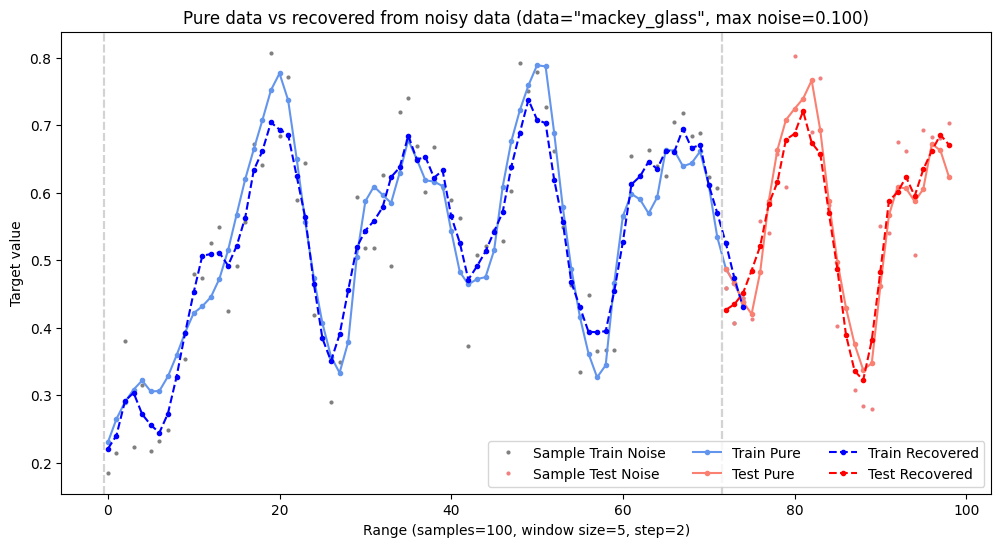

In [57]:
### Plot the original and recovered data with added performance metrics

# Prepare X, y lists for plotting
X_list = [X_train_pure_tens[0], X_test_pure_tens[0], 
          X_train_pure_tens[0], X_test_pure_tens[0], 
          X_train_pure_tens[0], X_test_pure_tens[0]]
y_list = [y_train_noisy_flat, y_test_noisy_flat,
          y_train_pure_flat, y_test_pure_flat, 
          pred_train_from_noisy_flat, pred_test_from_noisy_flat]

print()
multi_plot_flat_ts(
    y_list, X_list=X_list,
    colors=['none', 'none', 'cornflowerblue', 'salmon', 'blue', 'red'],
    marker_colors=['gray', 'lightcoral', 'cornflowerblue', 'salmon', 'blue', 'red'],
    labels=[
        'Sample Train Noise',
        'Sample Test Noise',
        'Train Pure',
        'Test Pure',
        'Train Recovered',
        'Test Recovered'
    ],
    lines=['dotted', 'dotted', 'solid', 'solid', 'dashed', 'dashed'],
    markers=['.', '.', '.', '.', '.', '.'],
    legend_cols=3,
    title=f'Pure data vs recovered from noisy data (data=\"{DATA_NAME}\", max noise={noise:0.3f})',
    xlabel=f'Range (samples={samples}, window size={wind_size}, step={wind_step})',
    #save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}/train_org_vs_recovered.eps'
)
print()